# Gaussian Processes for Machine Learning

## Gaussian Processes 

A Gaussian proccess is a paricular type of stochastic process. *But what do we understand by a stochastic process?* Typically, a stochastic process denotes a collection of random variables with a time dependence. Hence, the term *stochastic* is justified by the consideration of *random variables* and *process* relates to the *time dependence*. 
We state the following brief definition:

```{admonition} Definition
:class: tip
:name: def:tsp
A **(temporal) stochastic process** is a collection of $\mathbb{R}^d$-valued random variables $(X_t)_{t \in \mathcal{I}}$, where either $\mathcal{I} = \mathbb{N}$ (discrete-time) or $\mathcal{I} = \mathbb{R}_{>= 0}$ (continuous-time).
```

Hence, this kind of stochastic process describes the temporal process of random events. In this context, it makes sense to say that the outcome of $X_s$ happended before $X_t$ for $s < t$. Keep in mind that each random variable $X_t$ is a map $X_t: \Omega \rightarrow \mathbb{R}^d$ and $X_t(\omega)$ for $\omega \in \Omega$ is the outcome of a random experiment. The use of a stochastic process makes it possible to consider the outcomes of all random variables simultaneously. In this way, a so-called **sample path** or **random path** $(X_t(\omega))_{t \in \mathcal{I}}$ is obtained. The shape of these paths depend strongly on the underlying properties of the stochastic process.

A very famous example is Brownian motion (also called Wiener process) which has numerous applications in physics, finance, biology and many other areas. For example, the movement of a large particle (like pollen) due to collisions with small particles (like water molecules). A nice simulation can be found on the website of Andrew Duffy at Boston University (click to follow the link):

<a href="http://physics.bu.edu/~duffy/HTML5/brownian_motion.html"> <center><img src="bm.png"></center></a>

In one dimension, we can easily simulate sample paths of Brownian motion with $X_0 =0$:

<IPython.core.display.Javascript object>


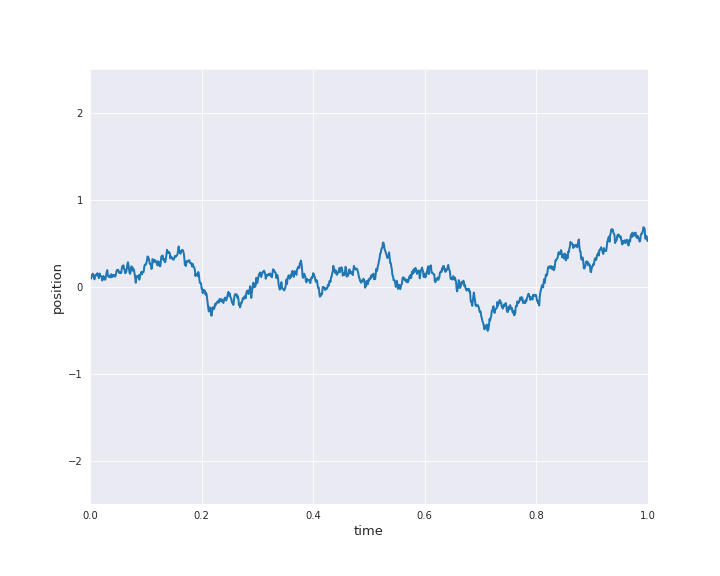

In [35]:
# Imports
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegFileWriter
import seaborn as sns
sns.set_style('darkgrid')

# 1D simulation of the Brownian motion process
total_time = 1
nb_steps = 1000
delta_t = total_time / nb_steps
mean = 0.  # Mean of each movement
stdev = np.sqrt(delta_t)  # Standard deviation of each movement
t = np.arange(0, total_time, delta_t)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(num='Brownian motion sample paths', figsize=(10, 8))
ax = plt.axes(xlim=(0, total_time), ylim=(-2.5, 2.5))
ax.set_xlabel('time', fontsize=13)
ax.set_ylabel('position', fontsize=13)
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    t = np.arange(0, total_time, delta_t)
    distances = np.cumsum(
        np.random.normal(
            mean, stdev, (1, nb_steps)),
        axis=1)
    line.set_data(t, distances)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=50, interval=400, blit=True)

anim.save('bm.gif', writer=FFMpegFileWriter(fps=2))


<img src="bm.gif" width="800px" alt="Brownian motion"/>

The concept can be generalized to general index sets and in particular, to $\mathbb{R}^d$. In the preceding animation random functions are genarted which provide for each input $t$ an output $f(t)$. For our machine learning applications we are interested in inputs $x \in \mathbb{R}^d$ and outputs $f(x) \in \mathbb{R}^d$. In other words, a time-index is to restrictive and therefore, we generalize the idea to arbitrary index sets. Moreover, in view of the nice properties of normal distributions an additional property is supposed:

```{admonition} Definition
:class: tip
:name: def:gp
A Gaussian process is a collection of real-valued random variables, any finite number of which have a joint Gaussian distribution.{cite}```Rasmussen2006```
```

Assume that $(f(x))_{x \in \mathcal{I}}$ denotes some Gaussian process. The additional condition means that for an arbitrary number of elements $x_i \in \mathcal{I}$, $i=1, \dots, n$, the $\mathbb{R}^n$-valued random vector 

$$\begin{pmatrix} f(x_1) \\ f(x_2) \\ \vdots \\ f(x_n) \end{pmatrix}$$

is mulivariate normally distributed. By construction the Gaussian process yields random functions from $\mathcal{I}$ to $\mathbb{R}$ and as stated before we will consider the case $\mathcal{I} = \mathbb{R}^d$.

## Kernels

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import matplotlib
import scipy
import scipy.spatial
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [3]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

## The Prior

Let’s first define a prior over functions with mean zero and a covariance matrix computed with kernel parameters l=1 and σf=1. To draw random functions from that GP we draw random samples from the corresponding multivariate normal. The following example draws three random samples

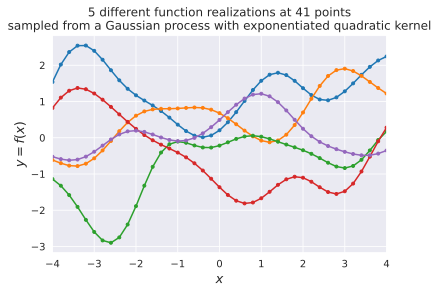

In [4]:
# Sample from the Gaussian process distribution
nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)
# Plot the sampled functions
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.xlim([-4, 4])
plt.show()

In [5]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [6]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

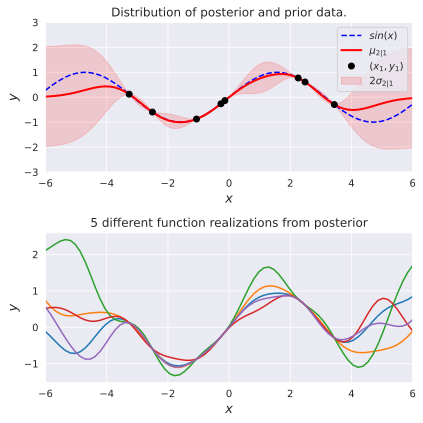

In [7]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()

```{bibliography}
:filter: docname in docnames
:style: plain
```